# Selecting a location for a well

Let's say you work for the mining company GlavRosGosNeft. We need to decide where to drill a new well.

You were provided with oil samples in three regions: in each 10,000 fields, where the quality of oil and the volume of its reserves were measured. Build a machine learning model that will help determine the region where mining will bring the greatest profit. Analyze the possible profits and risks using the *Bootstrap.* technique

Steps to select a location:

- Deposits are searched for in the selected region, and the characteristic values are determined for each;
- Build a model and estimate the volume of reserves;
- Deposits with the highest estimated values are selected. The number of fields depends on the company’s budget and the cost of developing one well;
- Profit is equal to the total profit of the selected fields.

1. Loading and preparing data

It is necessary to solve a regression problem, where the target feature is the volume of oil production.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (accuracy_score,
                             mean_squared_error,
                             confusion_matrix ,
                             f1_score,
                             roc_curve,
                             roc_auc_score
                            )




In [2]:
try:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')
        
except:
    df_0 = pd.read_csv('geo_data_0.csv')
    df_1 = pd.read_csv('geo_data_1.csv')
    df_2 = pd.read_csv('geo_data_2.csv')

In [3]:
display(df_0.head()), display(df_1.head()), display(df_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


(None, None, None)

In [4]:
df_0.info(), df_1.info(), df_2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

(None, None, None)

Let's look at the number of passes:

In [5]:
display(pd.DataFrame(round(df_0.isna().mean()*100,)).style.background_gradient('coolwarm'))
display(pd.DataFrame(round(df_1.isna().mean()*100,)).style.background_gradient('coolwarm'))
display(pd.DataFrame(round(df_2.isna().mean()*100,)).style.background_gradient('coolwarm'))

,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


No gaps found. Checking for **obvious** duplicates:

In [6]:
df_0.duplicated().sum(), df_1.duplicated().sum(), df_2.duplicated().sum()

(0, 0, 0)

Let's look at the boxplots of features:

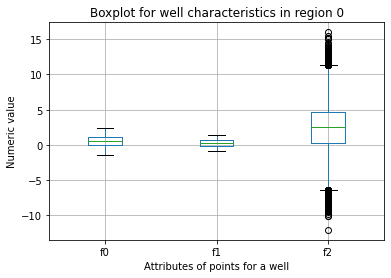

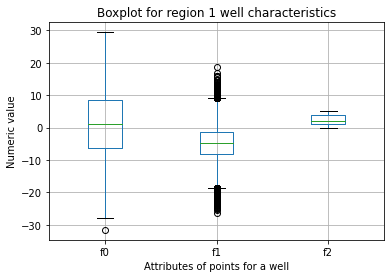

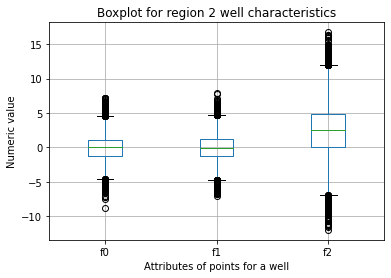

In [7]:
df_0.drop(['product'], axis=1).boxplot()
plt.title('Boxplot for well characteristics in region 0')
plt.ylabel('Numeric value')
plt.xlabel('Attributes of points for a well')
plt.show(
    
), df_1.drop(['product'], axis=1).boxplot()
plt.title('Boxplot for region 1 well characteristics')
plt.ylabel('Numeric value')
plt.xlabel('Attributes of points for a well')
plt.show()

df_2.drop(['product'], axis=1).boxplot()
plt.title('Boxplot for region 2 well characteristics')
plt.ylabel('Numeric value')
plt.xlabel('Attributes of points for a well')
plt.show()

<div class="alert alert-info">


Оси и графики подписала
    
</div>

We see that data normalization will be needed.

<div class="alert alert-info">

Дополняю проверку неявных дубликатов:
    
</div>

Checking for **implicit** duplicates:

In [8]:
df_0['id'].duplicated().sum(), df_1['id'].duplicated().sum(), df_2['id'].duplicated().sum()

(10, 4, 4)

We found 10 identical ids for df_0, 4 ids for df_1 and 4 ids for df_2, delete the corresponding rows from the data.

In [9]:
df_0=df_0[~df_0['id'].duplicated()]
df_1=df_1[~df_1['id'].duplicated()]
df_2=df_2[~df_2['id'].duplicated()]

In [10]:
df_0['id'].duplicated().sum(), df_1['id'].duplicated().sum(), df_2['id'].duplicated().sum()

(0, 0, 0)

Let's look at the distribution of the target variable 'product' depending on the region.

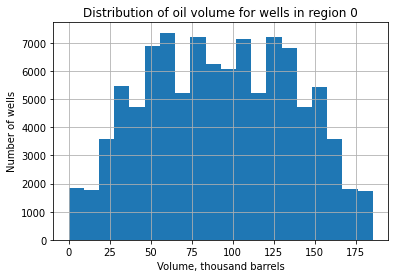

In [11]:
df_0['product'].hist(bins=20)
plt.title('Distribution of oil volume for wells in region 0')
plt.ylabel('Number of wells')
plt.xlabel('Volume, thousand barrels')
plt.show()

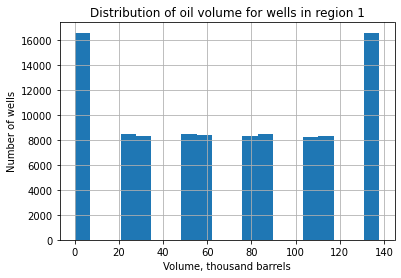

In [12]:
df_1['product'].hist(bins=20)
plt.title('Distribution of oil volume for wells in region 1')
plt.ylabel('Number of wells')
plt.xlabel('Volume, thousand barrels')
plt.show()

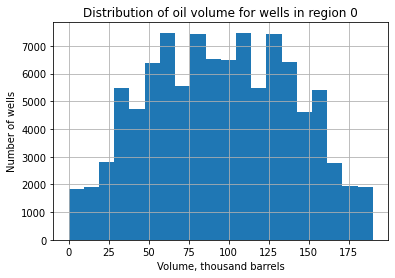

In [13]:
df_2['product'].hist(bins=20)
plt.title('Distribution of oil volume for wells in region 0')
plt.ylabel('Number of wells')
plt.xlabel('Volume, thousand barrels')
plt.show()

The distribution of the target variable 0 and 2 are similar and close to normal, and in region 1 there is a large value of wells with zero volume of raw materials and maximum...

Let's conduct a study on collinearity of features:

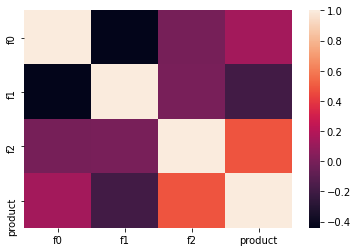

In [14]:
sns.heatmap(df_0.corr())
plt.show()

None of the features has a high correlation with the target feature; there is a very low correlation between f1, f0.

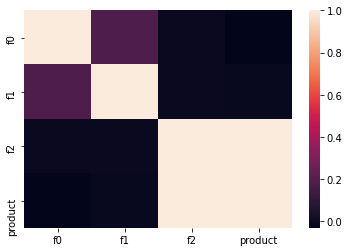

In [15]:
sns.heatmap(df_1.corr())
plt.show()

For region 1 there is also no strong correlation between the characteristics; there is a low correlation between all f0, f1, f2 and a high correlation between f2 and the target feature.

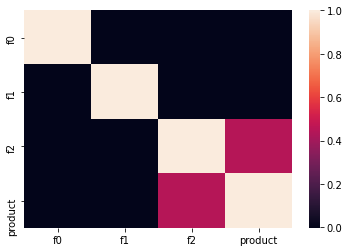

In [16]:
sns.heatmap(df_2.corr())
plt.show()

Also very low correlation between the target variable and other features.

Conclusion: a strong linear relationship between non-target features was not found for any of the regions.

**Conclusion from step 1:** Oil data for three regions has been imported, no gaps or duplicates were found, the data type is correct.

## Training and checking models

2.1. Split the data into training and validation sets in a ratio of 75:25.
  Let's remove the unnecessary 'id' column

2.2. Train the model and make predictions on the validation set.


Since we are using a linear model, we need to scale the numerical features:
Let's write a function to train the model:

2.3. Store predictions and correct answers on the validation set.

In [17]:
def split_sample(data):
    #разбивка
    data_target_train, data_target_valid, data_feature_train, data_feature_valid = train_test_split(
    data['product'],
        data.drop(['product','id'], axis=1), 
        test_size=0.25, 
        random_state=12345)
    
    #масштабирование
    scaler = StandardScaler()
    scaler.fit(data_feature_train)
    data_feature_train = scaler.transform(data_feature_train)
    data_feature_valid = scaler.transform(data_feature_valid)
    
    #обучение модели
    model = LinearRegression()
    model.fit(data_feature_train, data_target_train) 
    model.predict(data_feature_valid)
    
    
    #оценка среднего значения запаса в скажинах
    predictions_valid = model.predict(data_feature_valid) 
    reserve = round(predictions_valid.mean(),2)
        
    #print("Средний запас предсказзаного сырья для местности 0:", reserve_0)
    
    
    # значение метрики RMSE на валидационной выборке
    result = mean_squared_error(data_target_valid, predictions_valid)**0.5
    
    return data_target_train, data_target_valid, data_feature_train, data_feature_valid, predictions_valid, reserve, result
    

In [18]:
#определение признкаов и разбивка, оценка среднего объема и ошибки для df_0
df_0_target_train, df_0_target_valid, df_0_features_train, df_0_features_valid, predictions_valid_0, reserve_0, result_0 = split_sample(df_0)

#определение признкаов и разбивка ,оценка среднего объема и ошибки для df_1
df_1_target_train, df_1_target_valid, df_1_features_train, df_1_features_valid, predictions_valid_1, reserve_1, result_1 = split_sample(df_1)

#определение признкаов и разбивка ,оценка среднего объема и ошибки для df_2
df_2_target_train, df_2_target_valid, df_2_features_train, df_2_features_valid, predictions_valid_2, reserve_2, result_2 = split_sample(df_2)


In [19]:
df_0_features_train.shape, df_1_features_train.shape, df_2_features_train.shape

((74992, 3), (74997, 3), (74997, 3))

 2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели. 

In [20]:
 # средний запас предсказанного сырья
print("Average reserve of predicted raw materials for area 0:", reserve_0)

print("RMSE of linear regression model on validation set df_0:", result_0)

Average reserve of predicted raw materials for area 0: 92.79
RMSE of linear regression model on validation set df_0: 37.853527328872964


In [21]:
print("Average stock of predicted raw materials for area 1:", reserve_1)

print("RMSE of linear regression model on validation set df_1:", result_1)

Average stock of predicted raw materials for area 1: 69.18
RMSE of linear regression model on validation set df_1: 0.8920592647717033


In [22]:
print("Average reserve of predicted raw materials for area 2:", reserve_2)

print("RMSE of linear regression model on validation set df_2:", result_2)

Average reserve of predicted raw materials for area 2: 94.87
RMSE of linear regression model on validation set df_2: 40.07585073246016


The training showed that the largest supply of predicted raw materials is in the region for df_2, but the error is also the largest there, and in the region for df_1 it is the smallest.

## Preparation for profit calculation

Prepare to calculate your profit:

  3.1. Save all key values for calculations in separate variables.

Let's keep in the variables the price per thousand barrels of oil - 450 thousand rubles, the budget for the development of wells in the region - 10 billion rubles, 500 points for research and 200 of the best of them.

In [23]:
PRICE_PER_TSD_BARREL = 450000
COSTS_PER_REGION= 10*10**9
N_EXAMINE = 500
N_BEST = 200

3.2. Calculate the sufficient volume of raw materials to break even the development of a new well. Compare the resulting volume of raw materials with the average stock in each region

In [24]:
VOLUME_MIN = round(COSTS_PER_REGION/(PRICE_PER_TSD_BARREL*N_BEST) ,2)
VOLUME_MIN

111.11

The minimum production volume from one well must be no less than 111.11 thousand barrels for the well to break even.4

According to the calculations above, the average volume for each region is 92.79,69.18, 94.86 thousand barrels, which is lower than the required volume of 111.111 thousand barrels.

3.3. Write conclusions on the stage of preparing the profit calculation.

Based on calculations, the average volume of oil reserves in one well in any region does not reach the payback point of 111.11 thousand barrels. The largest average reserve reserve was found in region 1

During model training, the expected average volume of oil in wells was predicted and the break-even threshold was calculated. Since the calculation was carried out for all wells in each region, and from the distribution we saw that there was a significant portion of wells with zero reserves, the average value turned out to be below the payback point. During field development, 500 points will be explored, of which 200 will be developed and the risk and profit must be assessed. To do this, we will use the bootstrap technique.

## Calculation of profits and risks

Write a function to calculate profits for selected wells and model predictions:

  4.1. Select wells with maximum prediction values.
 
  4.2. Sum up the raw material volume target corresponding to these predictions.
 
  4.3. Calculate the profit for the received volume of raw materials.

In [25]:
def revenue(target, predictions,n ):
    #в целевом признаке сбросим индексы 
    target_reset = target.reset_index(drop=True)
    #преобразуем предсказания в объект Series, чтобы получить индексы, и отсортируем 
    predict_sorted = pd.Series(predictions).sort_values(ascending=False)
    #выберем целевое значение, соответствующее 200 макс. предсказаниям 
    selected = target_reset[predict_sorted.index][:n]  
    #посчитаем прибыль с этих скважин

    return (PRICE_PER_TSD_BARREL *selected.sum()-COSTS_PER_REGION)/10**6


We display the profit for the resulting volume for each region.

In [30]:
print("Profit from 200 wells with maximum oil reserves for region 0:", round(
    revenue(df_0_target_valid,predictions_valid_0, N_BEST),3),"mil rub")
print("for region 1:", round(revenue(df_1_target_valid,predictions_valid_1,N_BEST),3),"mil. rub.")
print("for region 2:", round(revenue(df_2_target_valid,predictions_valid_2,N_BEST),3),"mil. rub.")

Profit from 200 wells with maximum oil reserves for region 0: 3365.187 mil rub
for region 1: 2415.087 mil. rub.
for region 2: 2501.284 mil. rub.


The calculation shows that the greatest profit would be brought by wells developed in the region 0 - 3.365 billion rubles.

Calculate the risks and benefits for each region:

  5.1. Apply the Bootstrap technique with 1000 samples to find the profit distribution.
 
  5.2. Find the average return, 95% confidence interval, and risk of loss. A loss is a negative profit.
 
  5.3. Write your conclusions: suggest a region for well development and justify your choice.

In [33]:
state = np.random.RandomState(12345)   

def bootstrap_revenue(target, predictions):
    values = []
    for i in range(1000):
  
        target_subsample = target.reset_index(drop=True).sample(n=N_EXAMINE, replace=True, random_state=state)
        pred_subsample = predictions[target_subsample.index]
        values.append(revenue(target_subsample, pred_subsample, N_BEST))

    values = pd.Series(values)
    lower = values.quantile(0.025) 
    upper = values.quantile(0.975)
    confidence_interval = (lower, upper)

    mean = values.mean()
    print("Average revenue:", round(mean,2),"mln. rub.")
    loss_probability = round(((values < 0).mean()*100),2)
      
    print("Confidence interval, minimum:", round(lower,2),"million rubles.")
    print("Confidence interval, maximum:", round(upper,2),"million rubles.")
    print("Risks of loss:", loss_probability ,"%")
    print()


**GENERAL CONCLUSION:**
- Data were obtained for three regions with characteristics for each well. The data were analyzed and no preprocessing was required.

- A linear regression model was used for the study.

- The break-even point was found - 111.11 thousand barrels for one well.

- Profit was found for each region with the 200 most profitable wells: Profit from 200 wells with the maximum volume of oil reserves

     for region 0: 3365.187 million rubles.
    
     for region 1: 2415.087 million rubles.
    
     for region 2: 2501.284 million rubles.
    

  - Using the bootstrap technique, the average profit, 95% confidence interval and risk of loss for each region were found. It turned out that the lowest risk of loss in the region is 1-0.6% and the maximum profit is 479.16 million rubles.
 
  Based on this study, development should be carried out in Region 1.